In [1]:

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

from model.RandomForest import RandomForest

ModuleNotFoundError: No module named 'DecisionTree'

/tmp/ipykernel_90890/2715492406.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2016-01-01", end="2025-12-31")
[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Date                                                                 
2016-01-04   23.753147   23.757657   22.997827   23.135363  270597600
2016-01-05   23.157919   23.865891   23.090279   23.843345  223164000
2016-01-06   22.704721   23.081256   22.517584   22.673156  273829600
2016-01-07   21.746479   22.576205   21.741970   22.249276  324377600
2016-01-08   21.861464   22.346222   21.816370   22.219960  283192000
...                ...         ...         ...         ...        ...
2025-12-23  272.359985  272.500000  269.559998  270.839996   29642000
2025-12-24  273.809998  275.429993  272.200012  272.339996   17910600
2025-12-26  273.399994  275.369995  272.859985  274.160004   21521800
2025-12-29  273.760010  274.359985  272.350006  272.690002   23715200
2025-12-30  273.079987  274.079987  272.279999  272.809998   22139600

[2513 rows x 5 columns]


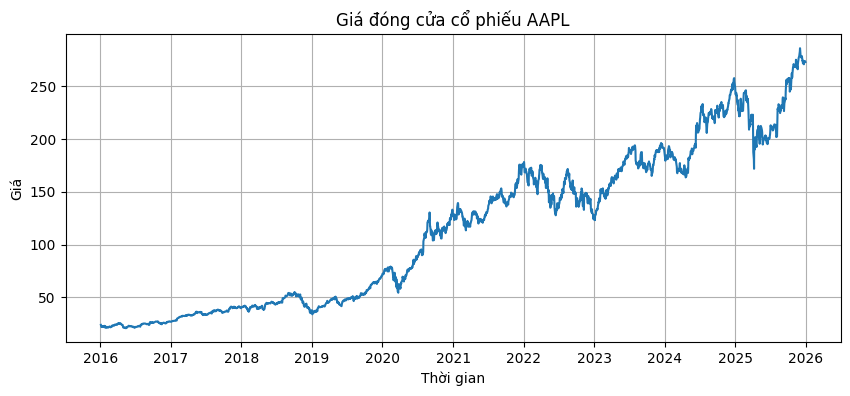

In [2]:
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2025-12-31"
df = yf.download(ticker, start="2016-01-01", end="2025-12-31")
df.columns = df.columns.droplevel(1)
print(df)

df.describe()

plt.figure(figsize=(10,4))
plt.plot(df.index, df['Close'])
plt.title(f'Giá đóng cửa cổ phiếu {ticker}')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.grid(True)
plt.show()

In [3]:
# --- 2. BỔ SUNG DỮ LIỆU VĨ MÔ (VIX, SP500, USD Index) ---
# Tải dữ liệu vĩ mô cùng khoảng thời gian
macro_tickers = ['^VIX', '^GSPC', 'DX-Y.NYB']
print("Đang tải dữ liệu vĩ mô...")
macro_data = yf.download(macro_tickers, start=start_date, end=end_date)['Close']

# Đổi tên cột cho dễ hiểu
macro_data.columns = ['dxy_close', 'sp500_close', 'vix_close']

# Gộp vào DataFrame chính (dùng left join để ưu tiên ngày giao dịch của AAPL)
df = df.join(macro_data, how='left')

# Xử lý dữ liệu thiếu (do lệch múi giờ hoặc ngày nghỉ lễ khác nhau) bằng cách lấy giá trị ngày trước đó
df[['dxy_close', 'sp500_close', 'vix_close']] = df[['dxy_close', 'sp500_close', 'vix_close']].ffill()

# Tạo đặc trưng biến động cho vĩ mô
df['vix_change'] = df['vix_close'].diff()        # Thay đổi của chỉ số sợ hãi
df['sp500_return'] = df['sp500_close'].pct_change() # Lợi nhuận thị trường chung
df['dxy_return'] = df['dxy_close'].pct_change()   # Sức mạnh đồng USD

Đang tải dữ liệu vĩ mô...


/tmp/ipykernel_90890/3313019627.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  macro_data = yf.download(macro_tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


In [4]:


# --- 1. Tính toán các đặc trưng cơ bản (Code cũ của bạn) ---
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df['volatility_5'] = df['log_return'].rolling(5).std()
df['ma_5'] = df['Close'].rolling(5).mean()
df['ma_10'] = df['Close'].rolling(10).mean()
df['high_low_range'] = (df['High'] - df['Low']) / df['Close']
df['open_close_change'] = (df['Close'] - df['Open']) / df['Open']

# --- 2. BỔ SUNG: Các chỉ báo nâng cao (Tâm lý & Dòng tiền) ---

# A. RSI (Relative Strength Index) - Chỉ báo Sợ hãi & Tham lam
# Chu kỳ thường dùng là 14 ngày. RSI > 70: Quá mua, RSI < 30: Quá bán.
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).ewm(span=14, adjust=False).mean()
loss = (-delta.where(delta < 0, 0)).ewm(span=14, adjust=False).mean()
rs = gain / loss
df['rsi_14'] = 100 - (100 / (1 + rs))

# B. Stochastic Oscillator (%K) - Động lượng giá
# So sánh giá đóng cửa với biên độ giá trong 14 ngày.
low_14 = df['Low'].rolling(window=14).min()
high_14 = df['High'].rolling(window=14).max()
df['stoch_k'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))

# C. Williams %R - Điểm đảo chiều
# Tương tự Stochastic nhưng thang đo từ -100 đến 0. > -20 là quá mua, < -80 là quá bán.
df['williams_r'] = ((high_14 - df['Close']) / (high_14 - low_14)) * -100

# D. MACD (Moving Average Convergence Divergence) - Xu hướng
# Chênh lệch giữa EMA 12 và EMA 26.
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema_12 - ema_26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean() # Đường tín hiệu

# E. On Balance Volume (OBV) - Dòng tiền thông minh
# Tích lũy khối lượng dựa trên việc giá tăng hay giảm.
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

# --- 3. Xử lý dữ liệu và tạo Target ---

# Loại bỏ các giá trị NaN sinh ra do rolling window (lớn nhất là 26 ngày của MACD)
df = df.dropna()

# Tạo target: Bạn đang dùng log_return của ngày hôm sau
df['target'] = df['log_return'].shift(-1)

# Loại bỏ hàng cuối cùng (vì shift(-1) sẽ tạo ra NaN ở dòng cuối)
df = df.dropna()

# Hiển thị kết quả
df.tail()

,Close,High,Low,Open,Volume,dxy_close,sp500_close,vix_close,vix_change,sp500_return,...,ma_10,high_low_range,open_close_change,rsi_14,stoch_k,williams_r,macd,macd_signal,obv,target
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-22,270.970001,273.880005,270.510010,272.859985,36571800,98.290001,6878.490234,14.08,-0.830000,0.006436,...,274.965997,0.012437,-0.006927,33.325447,18.550956,-81.449044,0.599715,2.070793,8.907775e+09,0.005117
2025-12-23,272.359985,272.500000,269.559998,270.839996,29642000,97.940002,6909.790039,14.00,-0.080000,0.004550,...,274.483997,0.010795,0.005612,40.430902,30.427298,-69.572702,0.370718,1.730778,8.937417e+09,0.005310
2025-12-24,273.809998,275.429993,272.200012,272.339996,17910600,97.980003,6932.049805,13.47,-0.530000,0.003221,...,273.986996,0.011796,0.005398,47.203381,48.343793,-51.656207,0.302751,1.445173,8.955328e+09,-0.001499
2025-12-26,273.399994,275.369995,272.859985,274.160004,21521800,98.019997,6929.939941,13.60,0.130000,-0.000304,...,273.523996,0.009181,-0.002772,45.515095,48.863565,-51.136435,0.213343,1.198807,8.933806e+09,0.001316
2025-12-29,273.760010,274.359985,272.350006,272.690002,23715200,98.040001,6905.740234,14.20,0.599999,-0.003492,...,273.071997,0.007342,0.003924,47.420432,51.590962,-48.409038,0.169582,0.992962,8.957521e+09,-0.002487


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1505 entries, 2020-01-03 to 2025-12-29
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Close              1505 non-null   float64
 1   High               1505 non-null   float64
 2   Low                1505 non-null   float64
 3   Open               1505 non-null   float64
 4   Volume             1505 non-null   int64  
 5   dxy_close          1505 non-null   float64
 6   sp500_close        1505 non-null   float64
 7   vix_close          1505 non-null   float64
 8   vix_change         1505 non-null   float64
 9   sp500_return       1505 non-null   float64
 10  dxy_return         1505 non-null   float64
 11  log_return         1505 non-null   float64
 12  volatility_5       1505 non-null   float64
 13  ma_5               1505 non-null   float64
 14  ma_10              1505 non-null   float64
 15  high_low_range     1505 non-null   float64
 16  open_c

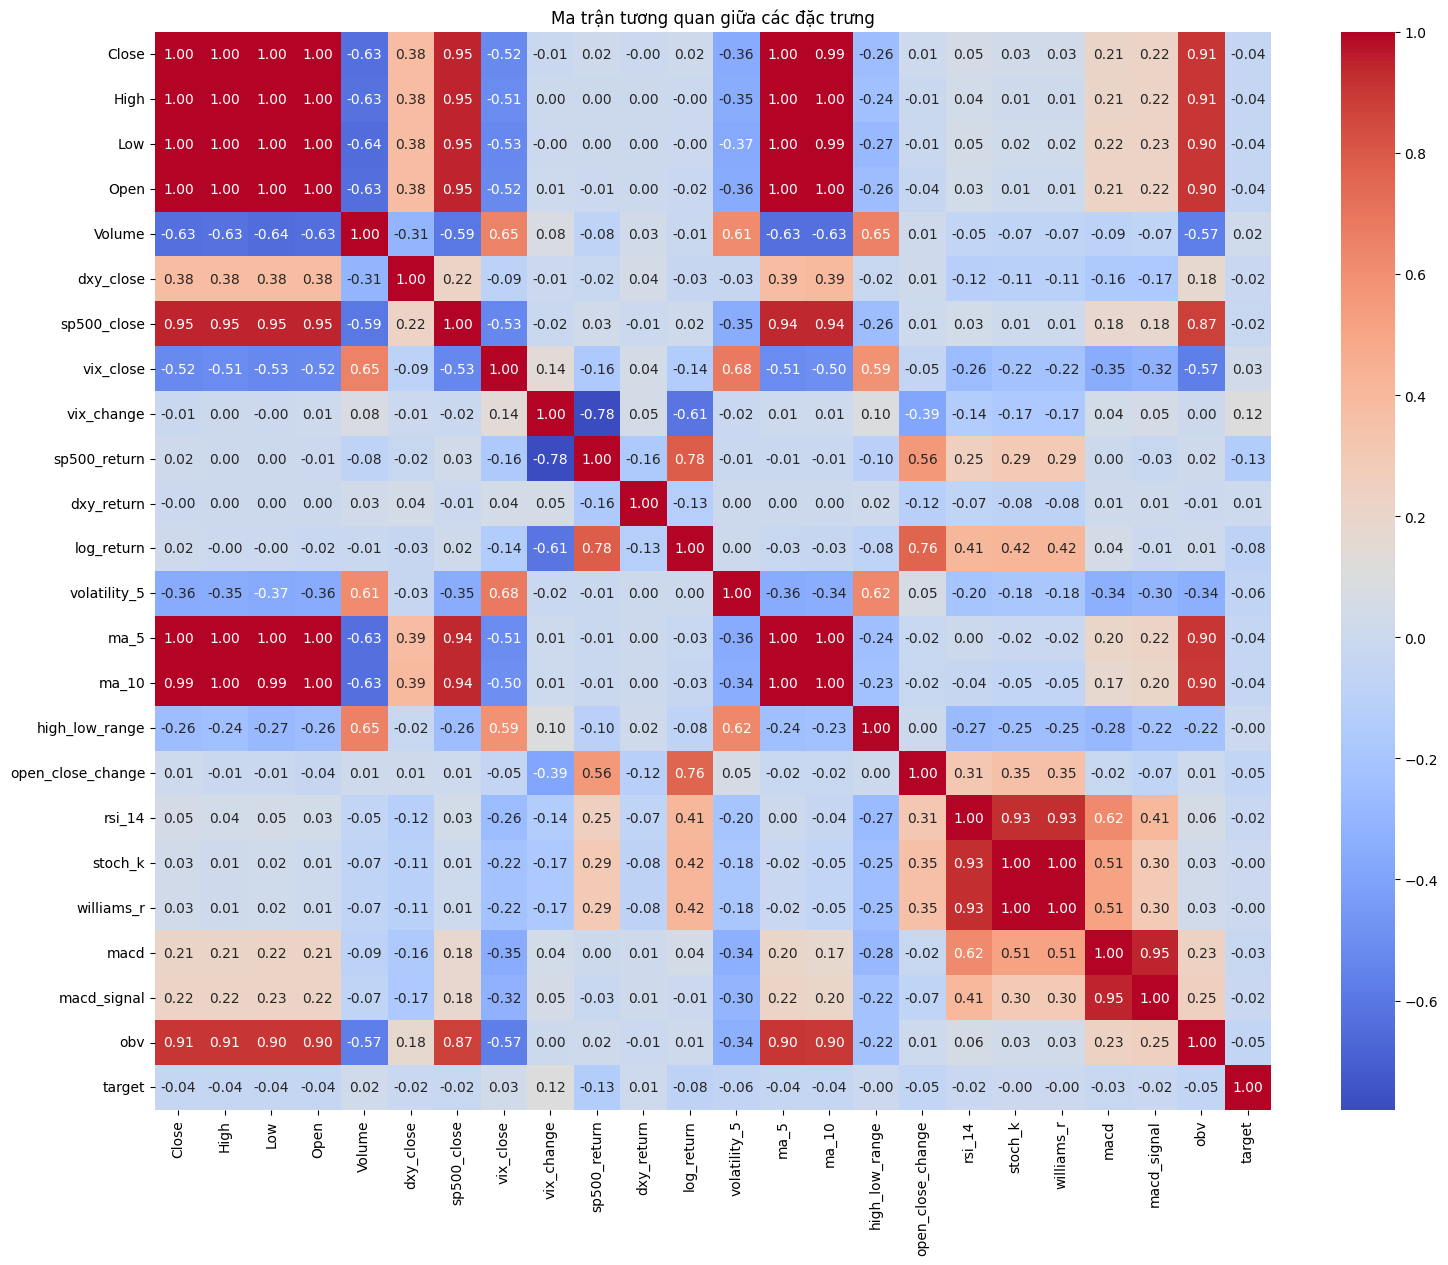

In [6]:
plt.figure(figsize=(18, 14))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các đặc trưng")
plt.show()

In [7]:
corr_matrix = df.corr()
target_corr = corr_matrix['target'].abs().sort_values(ascending=False)
top_features = target_corr.drop('target')
print(top_features.head(10))

sp500_return         0.134374
vix_change           0.115720
log_return           0.083989
volatility_5         0.057877
open_close_change    0.054800
obv                  0.054585
Close                0.040994
ma_5                 0.039732
High                 0.039615
Open                 0.039461
Name: target, dtype: float64


In [8]:
selected_features = [
    'Close',
    'log_return',
    'sp500_return',       
    'vix_change',
    
    'open_close_change',  
    'obv',         
    'ma_5',
    'volatility_5',
]

X = df[selected_features]
y = df['target']

Kích thước Train: 1279 | Kích thước Test: 226

Đang khởi tạo và huấn luyện Random Forest (Custom)...
Huấn luyện xong!
Đang dự báo trên tập Test...

KẾT QUẢ ĐÁNH GIÁ (CUSTOM RANDOM FOREST)
RMSE (Sai số giá):       4.4419
MAPE (Sai số %):         1.29%
Directional Accuracy:    50.44%


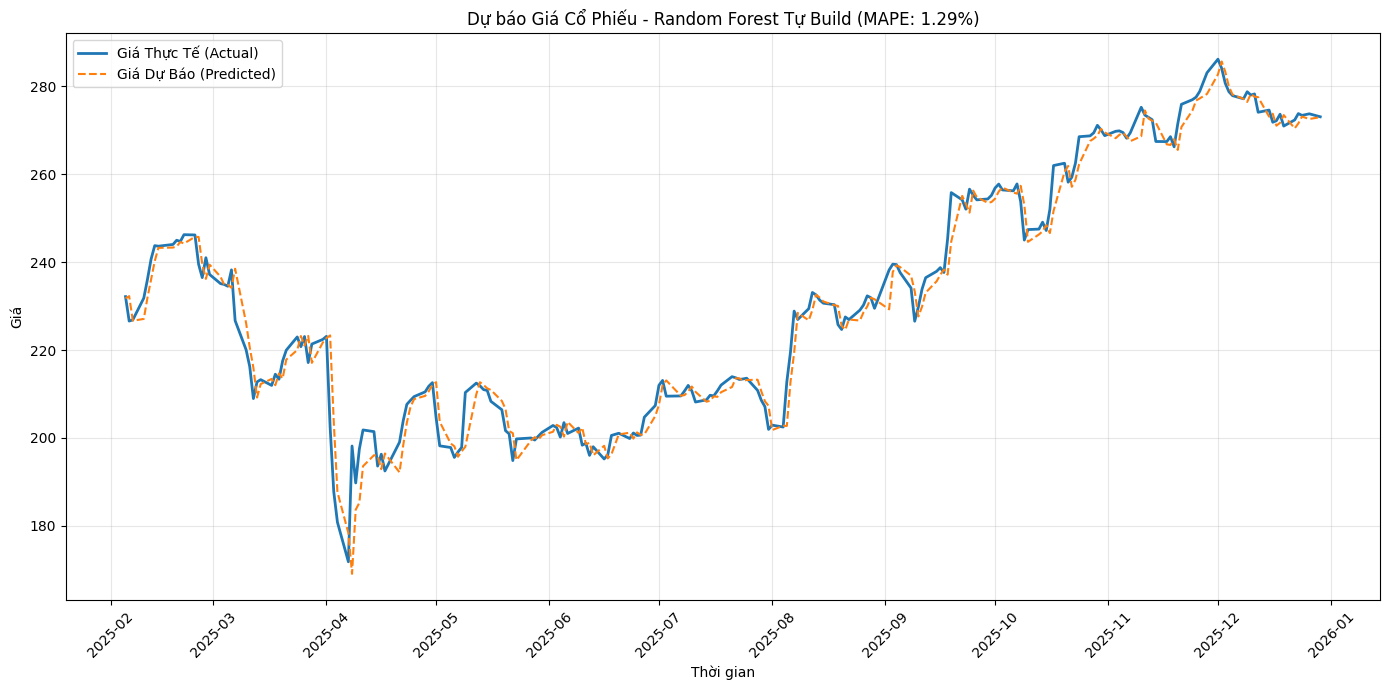

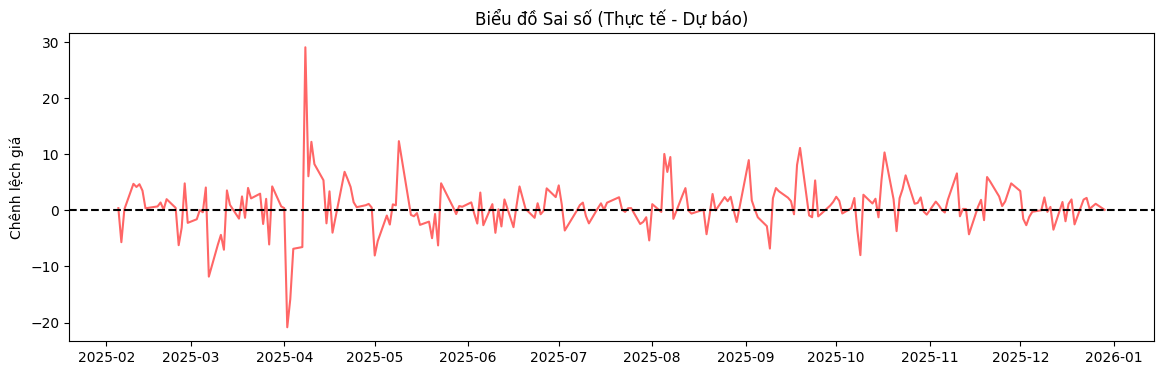

In [9]:
# --- BƯỚC 1: CHUẨN BỊ DỮ LIỆU CHO MÔ HÌNH TỰ BUILD ---

# 1. Chuyển đổi sang Numpy Array (Bắt buộc vì class Node dùng cú pháp array)
X_values = X.values
y_values = y.values

# 2. Chia tập dữ liệu theo thời gian (Time Series Split)
# Lấy 85% đầu để train, 15% sau để test
split_idx = int(len(X_values) * 0.85)

X_train, X_test = X_values[:split_idx], X_values[split_idx:]
y_train, y_test = y_values[:split_idx], y_values[split_idx:]

# 3. Lấy giá Close gốc của tập Test để phục vụ việc quy đổi giá (Price Reconstruction)
# Tìm vị trí cột 'Close' trong X để lấy giá nền
try:
    close_col_idx = selected_features.index('Close')
    base_prices_test = X_test[:, close_col_idx]
except ValueError:
    print("LỖI: Cần có cột 'Close' trong selected_features để quy đổi giá!")
    # Fallback: Lấy từ df gốc nếu không tìm thấy trong X
    base_prices_test = df['Close'].iloc[split_idx:].values

print(f"Kích thước Train: {len(X_train)} | Kích thước Test: {len(X_test)}")

# --- BƯỚC 2: HUẤN LUYỆN MÔ HÌNH RANDOM FOREST TỰ BUILD ---

print("\nĐang khởi tạo và huấn luyện Random Forest (Custom)...")
# Lưu ý: n_jobs=-1 để chạy song song đa nhân CPU
rf_custom = RandomForest(
    n_trees=100,            # Số lượng cây
    max_depth=10,           # Độ sâu tối đa
    min_samples_split=5,    # Số mẫu tối thiểu để tách nút
    n_features=int(X.shape[1] / 3), # Rule of thumb: features/3
    random_state=42,
    n_jobs=-1               
)

rf_custom.fit(X_train, y_train)
print("Huấn luyện xong!")

# --- BƯỚC 3: DỰ BÁO VÀ QUY ĐỔI GIÁ ---

print("Đang dự báo trên tập Test...")
# 1. Dự báo Log Return
y_pred_log_return = rf_custom.predict(X_test)

# 2. Quy đổi từ Log Return về Giá dự báo (Predicted Price)
# Công thức: Giá_dự_báo = Giá_hiện_tại * e^(log_return_dự_báo)
predicted_prices = base_prices_test * np.exp(y_pred_log_return)

# 3. Tính giá thực tế (Actual Price) từ log_return thực tế
actual_prices = base_prices_test * np.exp(y_test)

# --- BƯỚC 4: ĐÁNH GIÁ VÀ VẼ BIỂU ĐỒ ---

# Tính các chỉ số đánh giá
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

# Tính độ chính xác xu hướng (Directional Accuracy)
pred_direction = np.sign(y_pred_log_return)
true_direction = np.sign(y_test)
directional_acc = np.mean(pred_direction == true_direction) * 100

print("\n" + "="*40)
print("KẾT QUẢ ĐÁNH GIÁ (CUSTOM RANDOM FOREST)")
print("="*40)
print(f"RMSE (Sai số giá):       {rmse:.4f}")
print(f"MAPE (Sai số %):         {mape:.2f}%")
print(f"Directional Accuracy:    {directional_acc:.2f}%")

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
dates_test = df.index[split_idx:] # Lấy ngày tháng để trục hoành đẹp hơn

plt.plot(dates_test, actual_prices, label='Giá Thực Tế (Actual)', color='#1f77b4', linewidth=2)
plt.plot(dates_test, predicted_prices, label='Giá Dự Báo (Predicted)', color='#ff7f0e', linestyle='--', linewidth=1.5)

plt.title(f'Dự báo Giá Cổ Phiếu - Random Forest Tự Build (MAPE: {mape:.2f}%)')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Vẽ biểu đồ sai số (Residuals)
plt.figure(figsize=(14, 4))
errors = actual_prices - predicted_prices
plt.plot(dates_test, errors, color='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title('Biểu đồ Sai số (Thực tế - Dự báo)')
plt.ylabel('Chênh lệch giá')
plt.show()